# 소개

목표는 과거 데이터를 바탕으로 특정 상점에서 항목의 월별 판매량을 예측하는 것입니다. 판매 횟수는 0에서 20 사이로 잘립니다.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.preprocessing import LabelEncoder

import os
for dirname, _, filenames in os.walk('c:/k_dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load Data

In [2]:
# load data
df_items =pd.read_csv("./team/items.csv")
df_shops=pd.read_csv("./team/shops.csv")
df_item_categories=pd.read_csv("./team/item_categories.csv")
df_train=pd.read_csv("./team/sales_train.csv")
df_test=pd.read_csv("./team/test.csv")

# 1. Data Cleaning


# Remove outliers

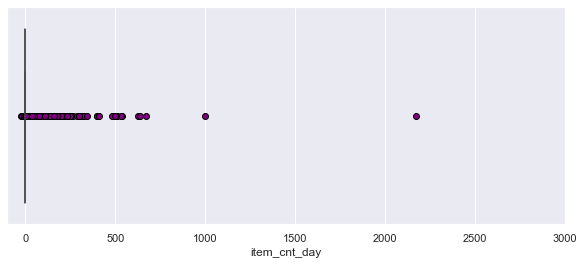

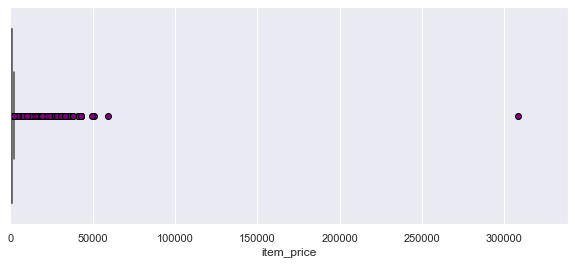

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=df_train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(df_train.item_price.min(), df_train.item_price.max()*1.1)
sns.boxplot(x=df_train.item_price, flierprops=flierprops)

데이터 셋에서 명백한 이상 값 (하루에 1000 개 이상 판매 된 항목과 가격이 300,000 개 이상인 항목)을 제거합니다.

In [4]:
df_train = df_train[(df_train.item_price < 300000 )& (df_train.item_cnt_day < 1000)]

항목 가격이 음수 인 행을 삭제

In [5]:
df_train = df_train[df_train.item_price > 0].reset_index(drop = True)
df_train.loc[df_train.item_cnt_day < 1, "item_cnt_day"] = 0

# Cleaning Shop Data

여러 상점이 서로 중복 된 것처럼 보입니다. 상점이 다시 문을 열거 나 동일한 거리 또는 쇼핑 센터에서 상점 위치를 이동할 수 있습니다.


In [6]:
# Якутск Орджоникидзе, 56
df_train.loc[df_train.shop_id == 0, 'shop_id'] = 57

df_test.loc[df_test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
df_train.loc[df_train.shop_id == 1, 'shop_id'] = 58
df_test.loc[df_test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
df_train.loc[df_train.shop_id == 10, 'shop_id'] = 11
df_test.loc[df_test.shop_id == 10, 'shop_id'] = 11

수치 데이터가 아닌 문자 데이터는 데이터 분석이 번거롭기때문에, 따라서 문자 데이터를 모두 수치 데이터로 Encoding하는 작업을 해줍니다.

In [7]:
 df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])

In [8]:
df_shops.loc[df_shops.city == '!Якутск', 'city'] = 'Якутск'

In [9]:
city_encoder = LabelEncoder()
df_shops['city_code'] = city_encoder.fit_transform(df_shops['city'])
df_shops = df_shops[['shop_id', 'city_code']]
df_shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


# Cleaning Item Category Data

In [10]:
df_item_categories.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [11]:
type_encoder = LabelEncoder()
df_item_categories['split_name'] = df_item_categories['item_category_name'].str.split(' - ')
df_item_categories['type'] = df_item_categories['split_name'].map(lambda x: x[0].strip())
df_item_categories['type_code'] = type_encoder.fit_transform(df_item_categories['type'])

In [12]:
df_item_categories.head(2)

,item_category_name,item_category_id,split_name,type,type_code
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,0
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,1


In [13]:
subtype_encoder = LabelEncoder()
df_item_categories['subtype'] = df_item_categories['split_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_item_categories['subtype_code'] = subtype_encoder.fit_transform(df_item_categories['subtype'])
df_item_categories = df_item_categories[['item_category_id', 'type_code', 'subtype_code']]

In [14]:
df_item_categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


# Cleaning Item Data

이미 item_id와 item_category_id가 숫자로 매핑되어 있어 name만 drop해줍니다.

In [15]:
df_items.drop(['item_name'], axis=1, inplace=True)

In [16]:
df_items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


In [17]:
df_shops.head(2)

,shop_id,city_code
0,0,29
1,1,29


In [18]:
df_item_categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


Clean item type

# Preprocessing

월이 증가하는 순서대로 월, 쇼핑 및 항목의 모든 조합으로 행렬 df를 만듭니다. Item_cnt_day는 item_cnt_month로 합산됩니다.

In [19]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = df_train[df_train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

19.76215434074402

In [20]:
# add revenue to train df
df_train["revenue"] = df_train["item_cnt_day"] * df_train["item_price"]

In [21]:
ts = time.time()
group = df_train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts

5.338227987289429

Create a test set for month 34.

In [22]:
df_test["date_block_num"] = 34
df_test["date_block_num"] = df_test["date_block_num"].astype(np.int8)
df_test["shop_id"] = df_test.shop_id.astype(np.int8)
df_test["item_id"] = df_test.item_id.astype(np.int16)

훈련 세트와 테스트 세트를 연결합니다.

In [23]:
ts = time.time()

matrix = pd.concat([matrix, df_test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.09474658966064453

상점, 항목 및 카테고리 데이터를 matrix df에 추가합니다.

In [24]:
ts = time.time()
matrix = pd.merge( matrix, df_shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, df_items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, df_item_categories, on = ["item_category_id"], how = "left" )
matrix["city_code"] = matrix["city_code"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

5.083630561828613

Feature Engineering

matrix df에 lag 추가

In [25]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

item_cnt_month lag 추가

In [26]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


21.947810411453247

전월 평균 item_cnt 추가

In [27]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


12.756825923919678

item_cnt_month의 lag 추가

In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


34.289841651916504

In [29]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

C:\Anaconda3\envs\store_amount_prediction\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_avg_item_cnt


40.364230155944824

month / shop / item 각각의 item_cnt_month lag 추가

In [30]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

C:\Anaconda3\envs\store_amount_prediction\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_item_avg_item_cnt


51.4684317111969

month / shop / item의 subtype에 대해 item_cnt_month lag 추가

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


17.15953230857849

month / city에 대한 item_cnt_month lag 추가

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "city_code"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


18.458032608032227

month / city / item에 대해 item_cnt_month lag 추가

In [33]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


27.183727502822876

* matrix df에 평균 품목 가격을 추가
* 월별 항목 가격의 lag 추가
* delta_price_lag 추가

In [34]:
ts = time.time()
group = df_train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = df_train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


221.82816219329834

* matix df에 매월 총 상점 수익을 더합니다.
* 월별 수익 lag 추가
* delta_revenue추가

In [35]:
ts = time.time()
group = df_train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


19.793540000915527

matrix df에 월과 일 수를 추가합니다.

In [36]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

각 상점의 달과 품목 첫 판매를 추가

In [37]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

2.365593671798706

행렬에서 처음 3 개월은 lag가 존재하지 않으므로 삭제합니다.

In [38]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

1.5796048641204834

In [39]:
matrix.head().T

,1497465,1497466,1497467,1497468,1497469
date_block_num,4.000000,4.000000,4.0,4.000000,4.000000
shop_id,2.000000,2.000000,2.0,2.000000,2.000000
item_id,27.000000,28.000000,29.0,30.000000,31.000000
item_cnt_month,0.000000,0.000000,0.0,0.000000,0.000000
city_code,0.000000,0.000000,0.0,0.000000,0.000000
item_category_id,19.000000,30.000000,23.0,40.000000,37.000000
type_code,5.000000,8.000000,5.0,11.000000,11.000000
subtype_code,12.000000,57.000000,18.0,6.000000,1.000000
item_cnt_month_lag_1,0.000000,0.000000,NaN,0.000000,1.000000
item_cnt_month_lag_2,0.000000,0.000000,NaN,1.000000,1.000000


# Modelling

In [40]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [41]:
data = matrix.copy()
del matrix
gc.collect()

20

In [42]:
data[data["date_block_num"]==34].shape

(214200, 30)


훈련을위한 검증으로 34 개월을 사용합니다.

In [43]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [44]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [45]:
del data
gc.collect();

In [52]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=10, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:1.17861	validation_1-rmse:1.11736
[1]	validation_0-rmse:1.12351	validation_1-rmse:1.07903
[2]	validation_0-rmse:1.07972	validation_1-rmse:1.04792
[3]	validation_0-rmse:1.04645	validation_1-rmse:1.02468
[4]	validation_0-rmse:1.01609	validation_1-rmse:1.00270
[5]	validation_0-rmse:0.98748	validation_1-rmse:0.98508
[6]	validation_0-rmse:0.96498	validation_1-rmse:0.97064
[7]	validation_0-rmse:0.94622	validation_1-rmse:0.95890
[8]	validation_0-rmse:0.92974	validation_1-rmse:0.94874
[9]	validation_0-rmse:0.91626	validation_1-rmse:0.94032
[10]	validation_0-rmse:0.90382	validation_1-rmse:0.93423
[11]	validation_0-rmse:0.89198	validation_1-rmse:0.92939
[12]	validation_0-rmse:0.88274	validation_1-rmse:0.92526
[13]	validation_0-rmse:0.87461	validation_1-rmse:0.92125
[14]	validation_0-rmse:0.86731	validation_1-rmse:0.91875
[15]	validation_0-rmse:0.86068	validation_1-rmse:0.91656
[16]	validation_0-rmse:0.85554	validation_1-rmse:0.91495
[17]	validation_0-rmse:0.85101	validation

1138.3397333621979

In [53]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

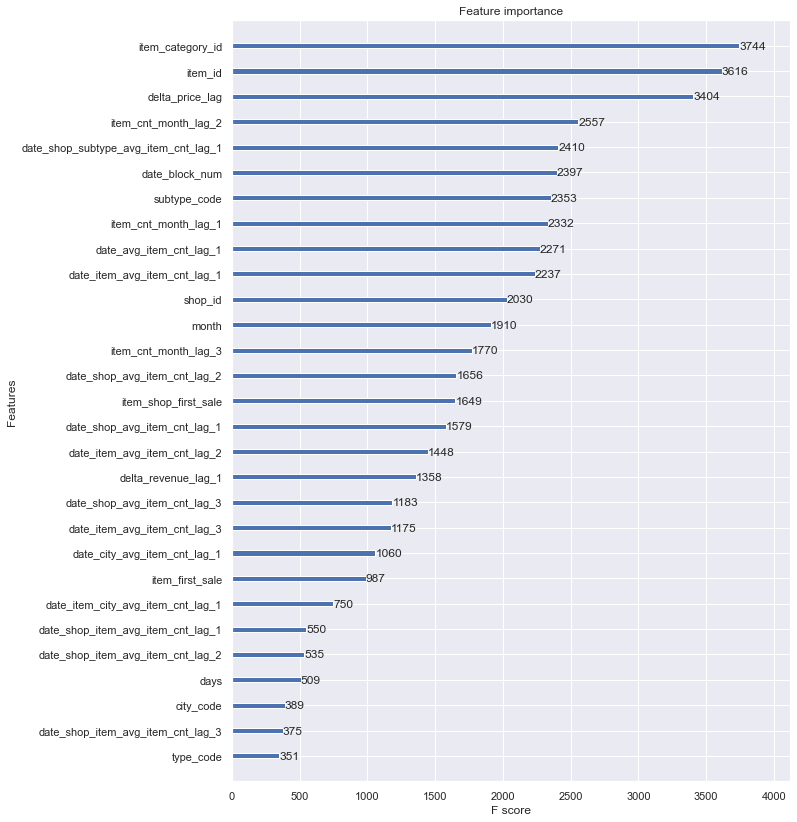

In [54]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))